In [2]:
import glob
files = glob.glob('all_eqs/*.jsonlist') 
eq_ct = 0
for f in files:
    with open(f) as processed:
        for i, line in enumerate(processed):
            eq_ct += 1

In [3]:
eq_ct

1881786

In [2]:
import json
import glob
files = glob.glob('all_eqs/*.jsonlist') 
def read(files, eq_ct):
    eqs = []
    for f in files:
        with open(f) as processed:
            for i, line in enumerate(processed):
                eqs.append(json.loads(line)['aligned'])
                eq_ct += 1
                if eq_ct == 10000: 
                    return eqs
eqs = read(files, 0)

In [3]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity

In [4]:
docs = [doc for sublist in eqs for doc in sublist]
dct = Dictionary(docs)
corpus = [dct.doc2bow(line) for line in docs]
model = TfidfModel(corpus)

In [5]:
index = MatrixSimilarity(model[corpus], num_features=len(dct))

In [6]:
line = docs[2]
sims = index[model[dct.doc2bow(line)]]
sims = sorted(enumerate(sims), key=lambda item: -item[1])

In [7]:
from gensim import interfaces, utils, matutils
import numpy as np
# query = matutils.sparse2full(query, self.num_features)
# query = numpy.asarray(query, dtype=self.index.dtype)

# do a little transposition dance to stop numpy from making a copy of
# self.index internally in numpy.dot (very slow).
# result = numpy.dot(self.index, query.T).T  

In [8]:
num_features = len(dct)
all_dists = []
for aligned_eqs in eqs:
    vecs = []
    for e in aligned_eqs: 
        sparse_vec = model[dct.doc2bow(e)]
        query = matutils.sparse2full(sparse_vec, num_features)
        query = np.asarray(query, dtype=np.float32)
        vecs.append(query)
    
    dists = []
    for i, v in enumerate(vecs):
        for j, v2 in enumerate(vecs):
            if i != j:
                dists.append(v.dot(v2))
    all_dists.extend(list(set(dists)))


In [9]:
# now do a random pass
N = len(eqs)
num_features = len(dct)
rand_dists = []
for aligned_eqs in eqs:
    vecs = []
    for e in aligned_eqs: 
        sparse_vec = model[dct.doc2bow(e)]
        query = matutils.sparse2full(sparse_vec, num_features)
        query = np.asarray(query, dtype=np.float32)
        vecs.append(query)
    
    dists = []
    for i, v in enumerate(vecs):
        # pick a random vector
        rand_i = np.random.randint(N)
        # Note: had to pull in a long range dependency on the docs list here. Could cause problems later.
        sparse_vec = model[dct.doc2bow(docs[rand_i])]
        rand_vec = matutils.sparse2full(sparse_vec, num_features)
        rand_vec = np.asarray(rand_vec, dtype=np.float32)
        dists.append(v.dot(rand_vec))
    rand_dists.extend(list(set(dists)))



In [10]:
len(rand_dists)

21202

In [11]:
len(all_dists)

12936

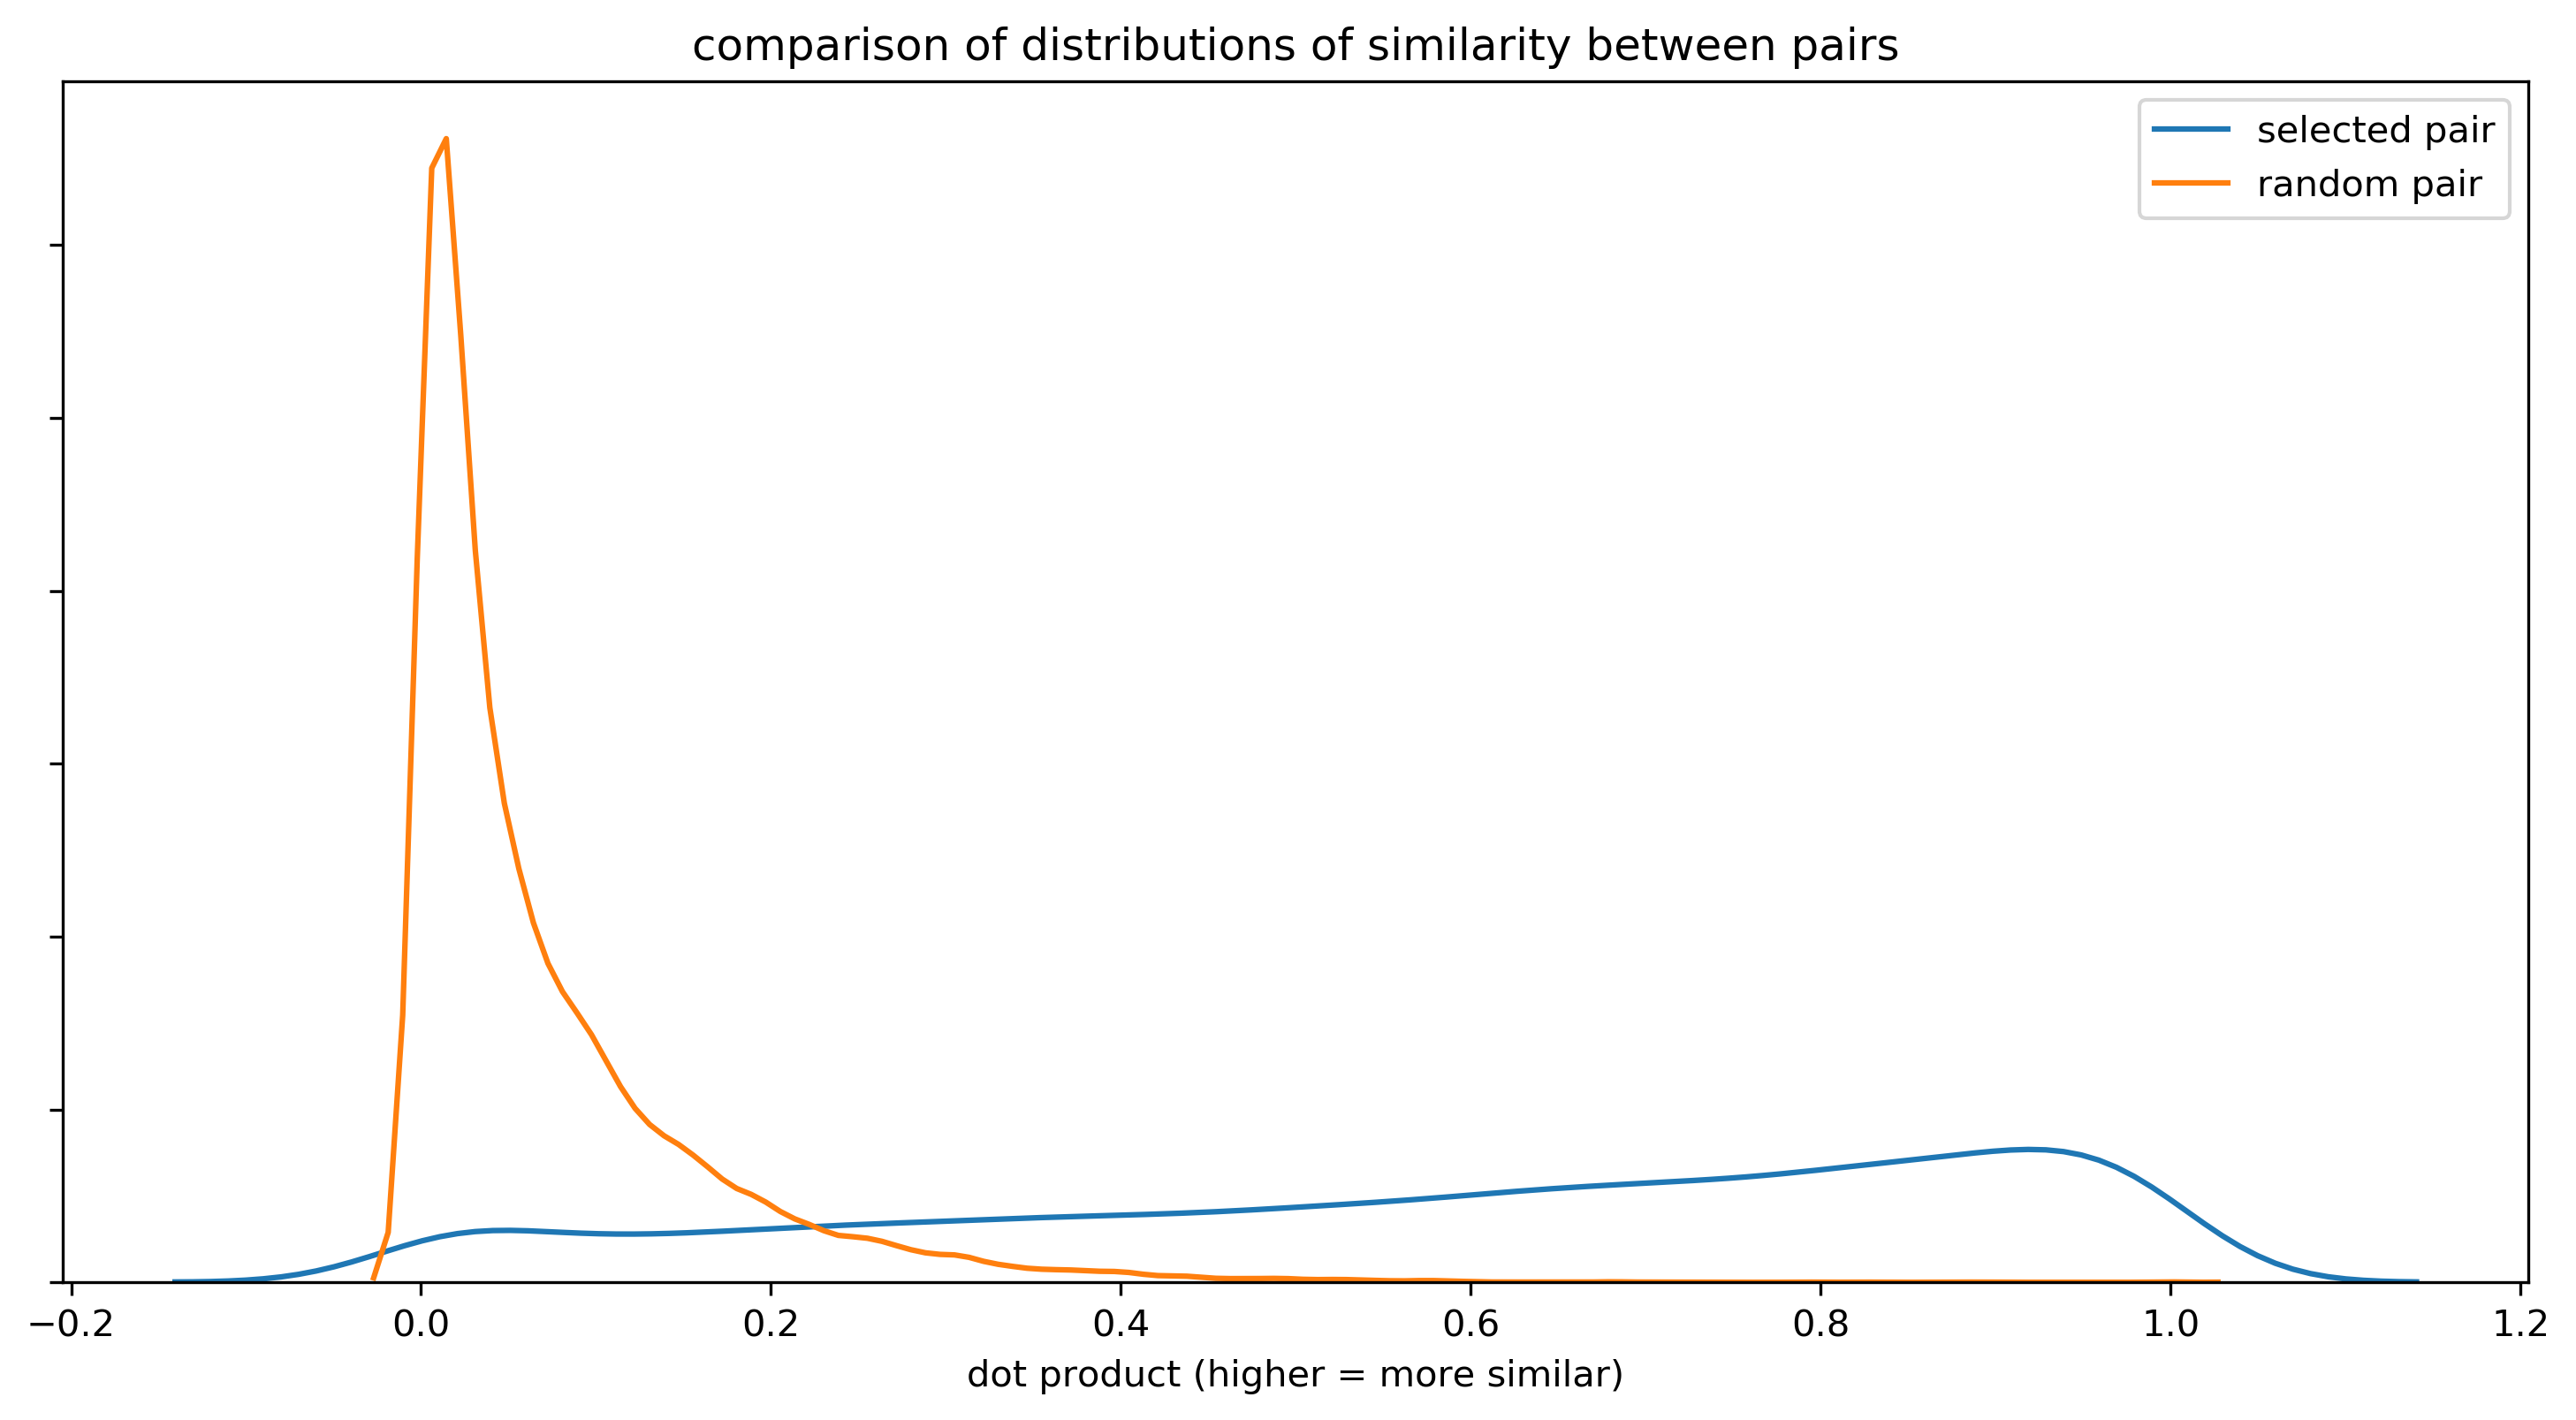

In [26]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# test = pd.DataFrame([all_dists, rand_dists])
fig, ax = plt.subplots(1, 1, figsize = (12, 6), dpi=300)

sns.distplot(all_dists, hist=False, rug=False, label='selected pair')
sns.distplot(rand_dists, hist=False, rug=False, label = 'random pair')
plt.setp( ax.get_yticklabels(), visible=False)  
ax.set_xlabel('dot product (higher = more similar)')
ax.set_title('comparison of distributions of similarity between pairs')



plt.savefig('report/pairs_comparison.png')

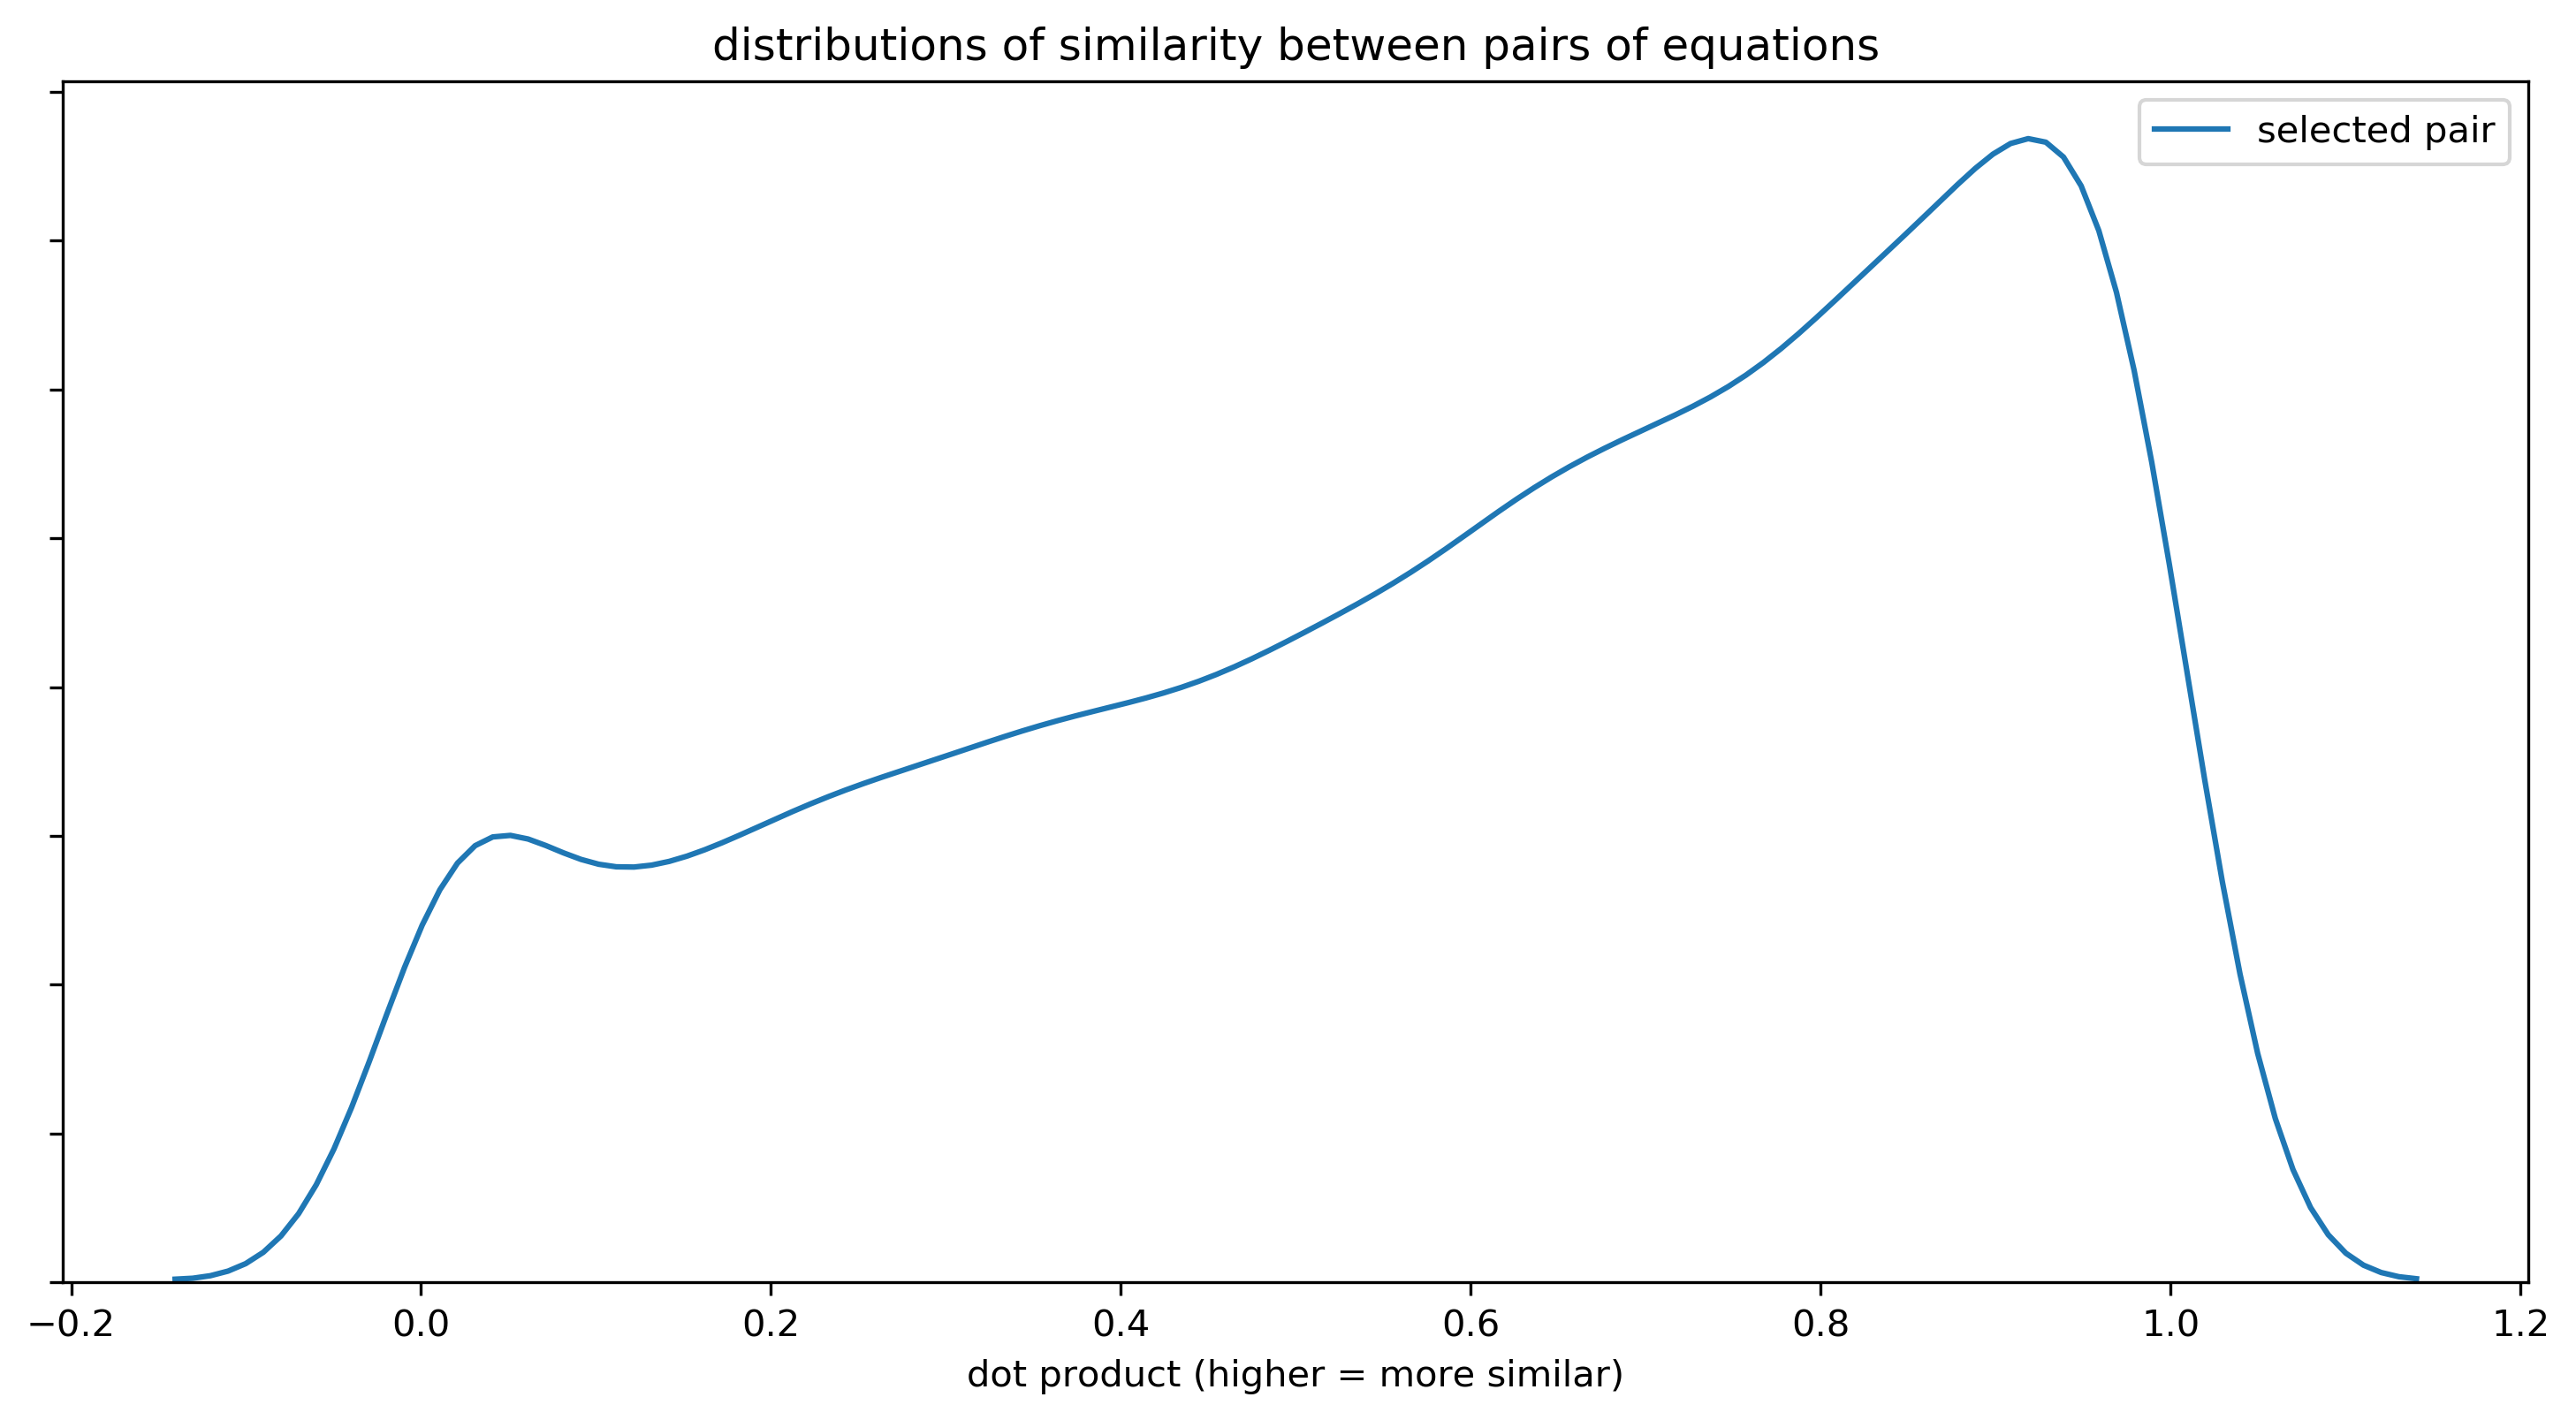

In [27]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# test = pd.DataFrame([all_dists, rand_dists])
fig, ax = plt.subplots(1, 1, figsize = (12, 6), dpi=300)

sns.distplot(all_dists, hist=False, rug=False, label='selected pair')
plt.setp( ax.get_yticklabels(), visible=False)  
ax.set_xlabel('dot product (higher = more similar)')
ax.set_title('distributions of similarity between pairs of equations')



plt.savefig('report/pairs_dist.png')